*Alumno: Alejandro Pérez Candela*

*Lab 6 - Técnicas de optimización de entrenamiento*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  Técnicas de optimización de entrenamiento

## 0. Importación de librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import random
import time

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Descargar recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling1D, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### 0.1. Fijar random seed:

In [ ]:
# Fijar la semilla aleatoria para reproducibilidad
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)  # Semilla de TensorFlow
np.random.seed(SEED_VALUE)  # Semilla de NumPy
random.seed(SEED_VALUE)  # Semilla de Python
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)  # Semilla para hash de Python para reproducibilidad

## 1. Carga del archivo CSV y análisis exploratorio de los datos

In [ ]:

file_path = '/content/drive/MyDrive/IMDB Dataset.csv'
df = pd.read_csv(file_path)

# Exploración inicial del DataFrame para entender la estructura
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Mostrar la cantidad de valores nulos por columna
print("Cantidad de valores nulos por columna:")
print(df.isnull().sum())

Cantidad de valores nulos por columna:
review       0
sentiment    0
dtype: int64


## 2. Preprocesamiento y limpieza del dataset

In [ ]:
# Preprocesar las reseñas (reviews)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Definimos una función para limpiar las sinopsis
def preprocess_text(text):
    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)

    # Convertir a minúsculas
    text = text.lower()

    # Reemplazar contracciones
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text)

    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)


    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenizar y eliminar stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lematizar
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]

    return ' '.join(words)

In [ ]:
df['review'] = df['review'].apply(preprocess_text)

In [ ]:
# Filtrar solo las clases 'Positive' y 'Negative'
df_filtered = df[df['sentiment'].isin(['positive', 'negative'])]

In [ ]:
# Mapear la columna 'sentiment' a valores numéricos
df_filtered['sentiment'] = df_filtered['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
df_filtered.head()

,review,sentiment
0,one reviewers mention watch oz episode hook ri...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stun fi...,1


In [ ]:
# Guardar el dataset limpiado a un archivo CSV
cleaned_file_path = "IMDB_Dataset_Cleaned.csv"
df_filtered.to_csv(cleaned_file_path, index=False)

## 3. Tokenización y creación de secuencias

In [ ]:
file_path = 'IMDB_Dataset_Cleaned.csv'
df = pd.read_csv(file_path)

# Exploración inicial del DataFrame para entender la estructura
df.head()

,review,sentiment
0,one reviewers mention watch oz episode hook ri...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stun fi...,1


In [ ]:
# Definir el tamaño del vector de embeddings
VECTOR_SIZE = 100

In [ ]:
# Tokenizar los textos para Word2Vec
reviews_tokenized = [review.split() for review in df['review']]

In [ ]:
# Entrenar el modelo Word2Vec
word2vec_model = Word2Vec(sentences=reviews_tokenized, vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)

In [ ]:
# Calcular la similitud del coseno entre los vectores de las palabras (opcional, para análisis exploratorio)
words = list(word2vec_model.wv.index_to_key)
word_vectors = tf.convert_to_tensor([word2vec_model.wv[word] for word in words], dtype=tf.float32)
similarity_matrix = tf.keras.losses.cosine_similarity(word_vectors, word_vectors)

In [ ]:
similarity = word2vec_model.wv.similarity('clear', 'light')
print(f"Similitud entre 'clear' and 'light': {similarity}\n")

similarity = word2vec_model.wv.similarity('good', 'great')
print(f"Similitud entre 'good' and 'great': {similarity}\n")

similarity = word2vec_model.wv.similarity('fuck', 'shit')
print(f"Similitud entre 'fuck' and 'shit': {similarity}\n")

similarity = word2vec_model.wv.similarity('hate', 'love')
print(f"Similitud entre 'hate' and 'love': {similarity}")


Similitud entre 'clear' and 'light': 0.21791428327560425

Similitud entre 'good' and 'great': 0.74188232421875

Similitud entre 'fuck' and 'shit': 0.5567280650138855

Similitud entre 'hate' and 'love': 0.5698704719543457


In [ ]:
# Find the 5 most similar words to 'hate'
try:
    similar_words = word2vec_model.wv.most_similar('nice', topn=5)
    print("5 palabras más similares a 'nice':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity}")
except KeyError:
    print("'love' is not in the vocabulary.")

5 palabras más similares a 'nice':
neat: 0.7157595157623291
cool: 0.6905003786087036
good: 0.6708120703697205
odd: 0.6191279292106628
great: 0.60310959815979


In [ ]:
# Tokenizar los textos y convertirlos a secuencias
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['review'])
X = tokenizer.texts_to_sequences(df['review'])

In [ ]:
# Rellenar las secuencias para que tengan la misma longitud
max_sequence_length = max(len(seq) for seq in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_sequence_length)

In [ ]:
# Dividir en conjuntos de entrenamiento y validación primero removiendo la etiqueta
y = df['sentiment'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Preparar la matriz de embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
embedding_matrix.shape

(195207, 100)

## 4. Definir el modelo

### Funciones que utilizaremos:

In [ ]:
# Función para graficar valores de entrenamiento y validación
def graficar_entrenamiento(histories, labels, colors):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for history, label, color in zip(histories, labels, colors):
        axes[0].plot(history.history['accuracy'], color=color, linestyle='-', label=f'{label} Train')
        axes[0].plot(history.history['val_accuracy'], color=color, linestyle='--', label=f'{label} Validation')
    axes[0].set_title('Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    for history, label, color in zip(histories, labels, colors):
        axes[1].plot(history.history['loss'], color=color, linestyle='-', label=f'{label} Train')
        axes[1].plot(history.history['val_loss'], color=color, linestyle='--', label=f'{label} Validation')
    axes[1].set_title('Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Método para probar el modelo con una nueva reseña
def probar_modelo(reseña, model):
    reseña_procesada = preprocess_text(reseña)
    secuencia = tokenizer.texts_to_sequences([reseña_procesada])
    secuencia_padded = tf.keras.preprocessing.sequence.pad_sequences(secuencia, maxlen=max_sequence_length)
    prediccion = model.predict(secuencia_padded)
    if prediccion >= 0.5:
        print("Reseña positiva")
    else:
        print("Reseña negativa")

In [ ]:
# Función para mostrar la matriz de confusión del modelo
def mostrar_matriz_confusion(modelo, X_val, y_val):
    y_pred = (modelo.predict(X_val) >= 0.5).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [ ]:
# Función para graficar la duración del entrenamiento de varios modelos en un gráfico de barras.
def plot_training_duration(models, durations):
    plt.figure(figsize=(10, 6))
    plt.bar(models, durations, color='skyblue')
    plt.xlabel('Modelos', fontsize=12)
    plt.ylabel('Duración del Entrenamiento (segundos)', fontsize=12)
    plt.title('Duración del Entrenamiento por Modelo', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 4.1. Comenzamos con el modelo más simple:

In [ ]:
# Definir un modelo simplista
model_simple = Sequential()
model_simple.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=VECTOR_SIZE,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=True))
model_simple.add(Flatten())
model_simple.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Entrenar el modelo
start_time = time.time()
simple_history = model_simple.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_simple = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_simple,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7768 - loss: 0.5366 - val_accuracy: 0.8411 - val_loss: 0.4851
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8931 - loss: 0.2931 - val_accuracy: 0.8388 - val_loss: 0.5550
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9488 - loss: 0.1359 - val_accuracy: 0.8439 - val_loss: 0.6085
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9814 - loss: 0.0585 - val_accuracy: 0.8437 - val_loss: 0.7014
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9900 - loss: 0.0319 - val_accuracy: 0.8397 - val_loss: 0.8650
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9921 - loss: 0.0272 - val_accuracy: 0.8398 - val_loss: 0.9666
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9937 - loss: 0.0211 - val_accuracy: 0.8426 - val_loss: 1.0481
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9936 - loss: 0.0

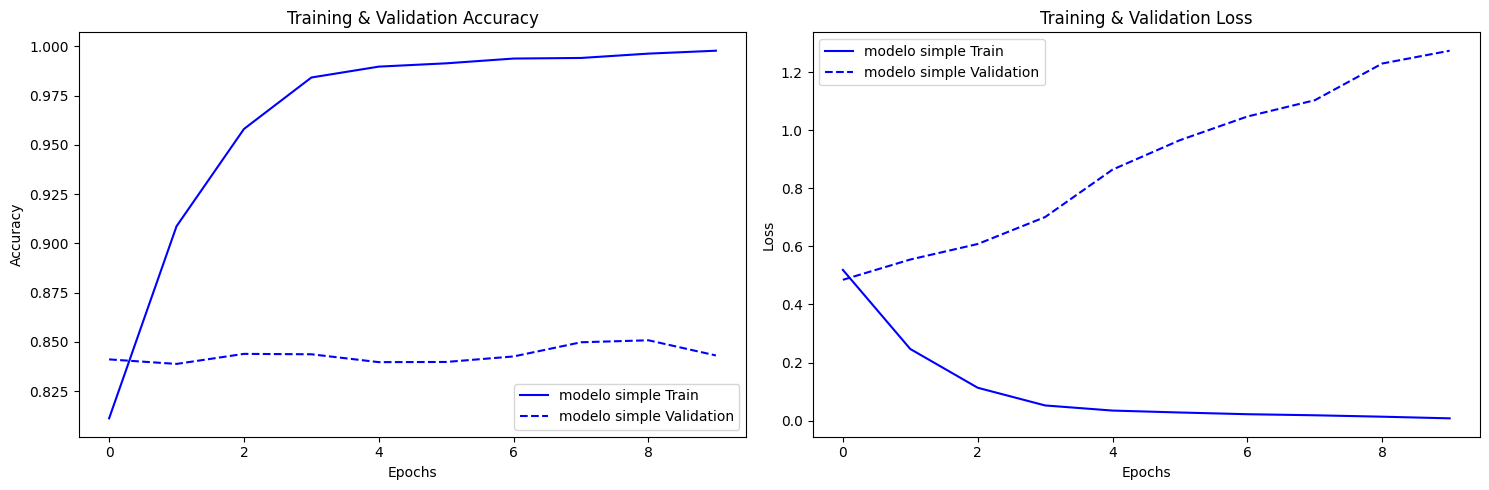

In [ ]:
graficar_entrenamiento([simple_history], ['modelo simple'], ['b'])

### Conclusiones:

Hay un overfiting muy marcado que puede verse en los datos de validación.

### 4.2. Reducir el overfitting

#### 4.2.1 Probemos con una capa Dropout:

Utilizaremos una única capa de Dropout al 30%, es bastante porcentaje pero visto el gran overfitting que tenemos...

In [ ]:
# Definir un nuevo modelo para reducir el overfitting
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=VECTOR_SIZE,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=True))
model_dropout.add(Flatten())
model_dropout.add(Dropout(0.3))  # Añadido Dropout para reducir overfitting
model_dropout.add(Dense(1, activation='sigmoid'))

# Compilar el nuevo modelo
model_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
start_time = time.time()
dropout_history = model_dropout.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_dropout = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_dropout,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7570 - loss: 0.5902 - val_accuracy: 0.8342 - val_loss: 0.5042
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8550 - loss: 0.4249 - val_accuracy: 0.8421 - val_loss: 0.5340
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8939 - loss: 0.3138 - val_accuracy: 0.8443 - val_loss: 0.6154
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9171 - loss: 0.2535 - val_accuracy: 0.8498 - val_loss: 0.6501
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9335 - loss: 0.1992 - val_accuracy: 0.8474 - val_loss: 0.7536
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9502 - loss: 0.1524 - val_accuracy: 0.8554 - val_loss: 0.7630
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9535 - loss: 0.1464 - val_accuracy: 0.8544 - val_loss: 0.8582
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9611 - loss: 0.

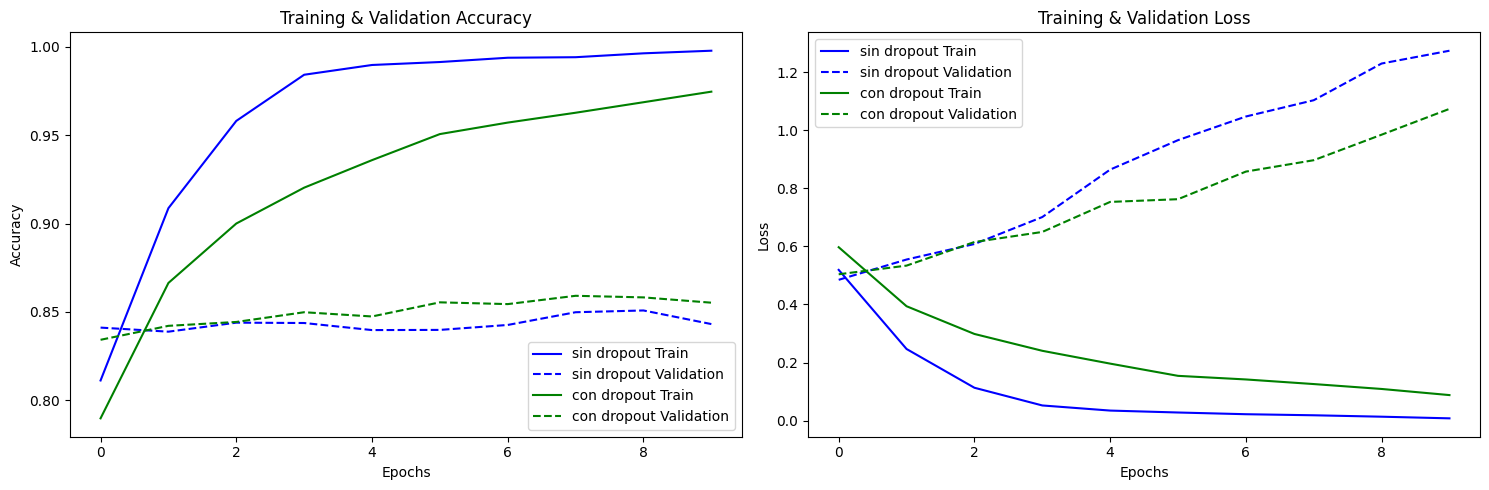

In [ ]:
graficar_entrenamiento([simple_history, dropout_history], ['sin dropout', 'con dropout'], ['b', 'g'])

El overfiting se ha reducido un poco como era de esperar, pero no del todo ni mucho menos. Además, está penalizando mucho el entrenamiento. Se necesitarían muchas más épocas, lo que resultaría ineficiente, y seguiría teniendo un grave problema de overfiting.

#### 4.2.2 Probemos con una capa GlobalAveragePooling1D

In [ ]:
# Definir un modelo simple de red neuronal
model_GAP1D = Sequential()
model_GAP1D.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model_GAP1D.add(GlobalAveragePooling1D())
model_GAP1D.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compilar el modelo
model_GAP1D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
start_time = time.time()
GAP1D_history = model_GAP1D.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_GAP1D = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GAP1D,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6809 - loss: 0.6761 - val_accuracy: 0.7683 - val_loss: 0.6352
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7622 - loss: 0.6273 - val_accuracy: 0.7762 - val_loss: 0.5979
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7722 - loss: 0.5940 - val_accuracy: 0.7828 - val_loss: 0.5708
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7801 - loss: 0.5692 - val_accuracy: 0.7914 - val_loss: 0.5498
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7865 - loss: 0.5498 - val_accuracy: 0.7964 - val_loss: 0.5330
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7928 - loss: 0.5340 - val_accuracy: 0.8019 - val_loss: 0.5190
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7987 - loss: 0.5209 - val_accuracy: 0.8057 - val_loss: 0.5072
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8029 - loss: 0.5096 - 

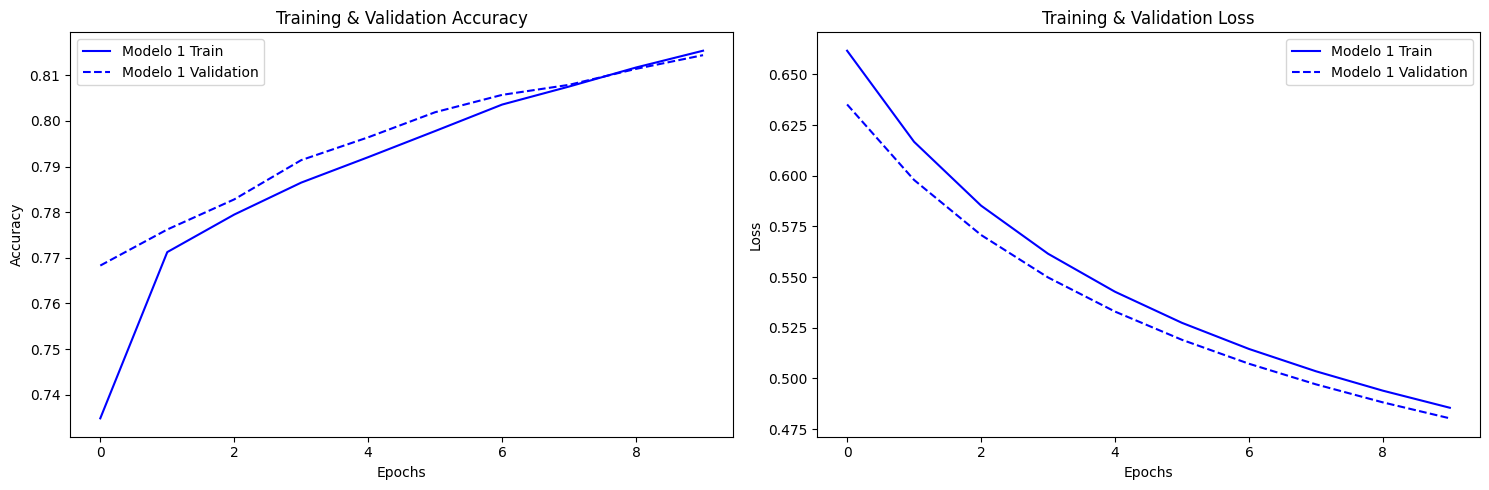

In [ ]:
# Graficar resultados del modelo
graficar_entrenamiento([GAP1D_history], ['Modelo 1'], ['blue'])

In [ ]:

# Probar el modelo con una reseña
probar_modelo("love", model_GAP1D)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Reseña positiva


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


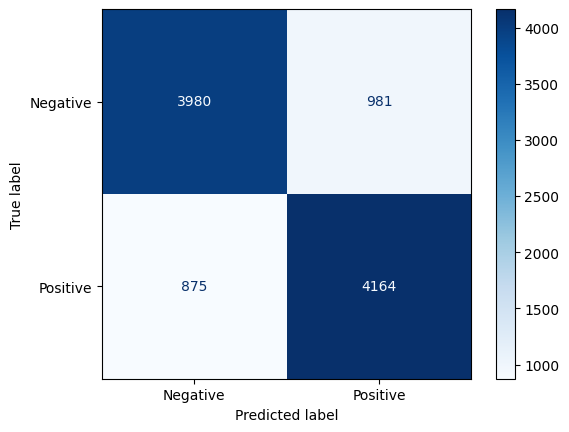

In [ ]:
# Mostrar la matriz de confusión del modelo
mostrar_matriz_confusion(model_GAP1D, X_val, y_val)

### Conclusiones sobre la reducción de overfitting:

El uso de Dropout al 30% no funcionó en mi modelo porque, aunque introduce ruido apagando algunas neuronas para que el modelo no se ajuste a detalles específicos, la tasa que elegí quizás no era la correcta. Si es muy alta, el modelo no aprende bien, y si es baja, no generaliza lo suficiente. Además, en modelos simples como el mío, Dropout no tiene tanto impacto como en redes más complejas.

Por otro lado, la capa GlobalAveragePooling1D resolvió el problema de overfitting porque reduce la dimensionalidad tomando el promedio de toda la secuencia. Esto simplifica la información, permitiendo que el modelo aprenda una representación más general y evitando que se ajuste demasiado a detalles específicos o ruido.

En resumen, GlobalAveragePooling1D ayudó porque simplifica la representación de los datos, mientras que Dropout no fue suficiente en mi caso.

Ahora que nuestro modelo es "medio decente", es hora de probar con diferentes batch sizes.

### 4.3 Probar con diferentes batch sizes

In [ ]:
start_time = time.time()
history_16 = model_GAP1D.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))
end_time = time.time()
duration_batch_16 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_batch_16,2)} segundos")

start_time = time.time()
history_64 = model_GAP1D.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_batch_64 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_batch_64,2)} segundos")

start_time = time.time()
history_128 = model_GAP1D.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_batch_128 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_batch_128,2)} segundos")

start_time = time.time()
history_256 = model_GAP1D.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_256 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_256,2)} segundos")

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8152 - loss: 0.4825 - val_accuracy: 0.8205 - val_loss: 0.4693
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8199 - loss: 0.4725 - val_accuracy: 0.8240 - val_loss: 0.4607
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8229 - loss: 0.4643 - val_accuracy: 0.8276 - val_loss: 0.4533
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8262 - loss: 0.4571 - val_accuracy: 0.8296 - val_loss: 0.4467
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8286 - loss: 0.4508 - val_accuracy: 0.8310 - val_loss: 0.4409
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8307 - loss: 0.4452 - val_accuracy: 0.8333 - val_loss: 0.4356
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8322 - loss: 0.4402 - val_accuracy: 0.8342 - val_loss: 0.4309
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8337 - loss: 0.4357 - 

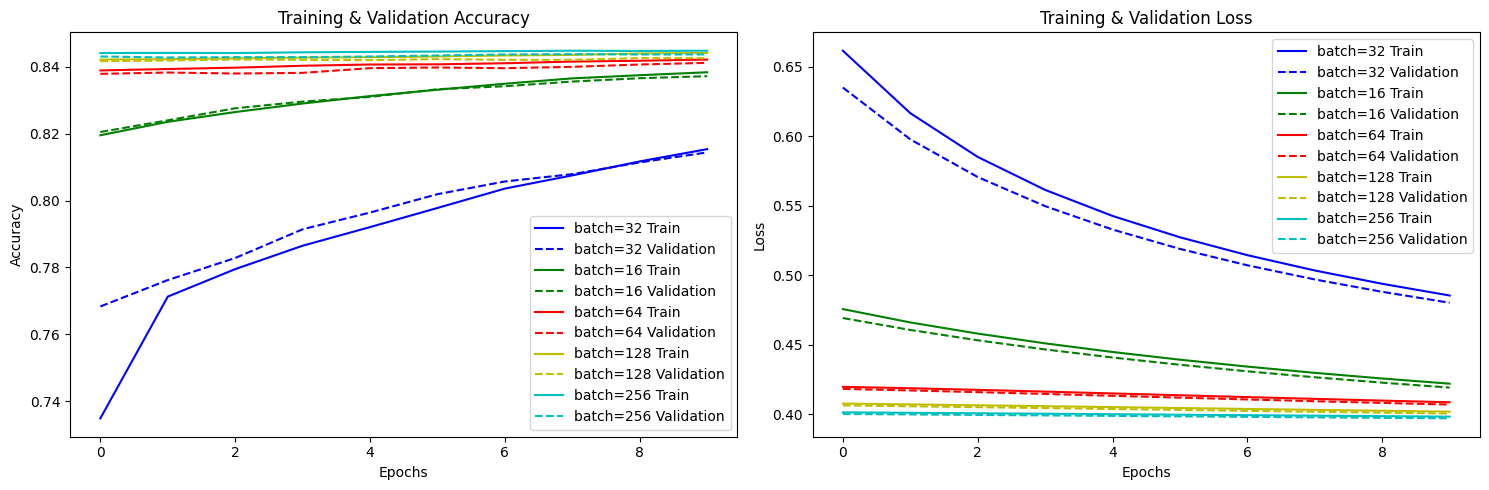

In [ ]:
graficar_entrenamiento([GAP1D_history, history_16, history_64, history_128, history_256], ['batch=32', 'batch=16', 'batch=64', 'batch=128', 'batch=256'], ['b', 'g', 'r', 'y', 'c'])

### Conclusiones sobre la elección de batch size:

#### Accuracy:
El batch size de 32 parece mostrar una mejoría constante en el entrenamiento, alcanzando una mayor precisión en el conjunto de entrenamiento en comparación con el batch size de 16.
En cuanto a la precisión en la validación, las líneas para el batch size de 16 y 32 parecen converger o estar muy cercanas. Esto sugiere que ambos tamaños de batch tienen un comportamiento similar en la validación, pero el batch de 32 tiene una mejor curva de aprendizaje durante el entrenamiento.


#### Pérdida (Loss):
El batch size de 32 tiene una mayor pérdida en las primeras épocas, pero decrece de manera constante. Al final, el modelo con batch size de 32 sigue mejorando, mientras que el batch de 16 tiene una pérdida más baja desde el principio pero menos variabilidad en la reducción.
En validación, ambos muestran curvas muy similares, pero el batch size de 32 parece tener una ligera ventaja al reducir más la pérdida hacia el final.
Conclusión:
El batch size de 32 parece ofrecer un mejor balance entre el entrenamiento y la validación, mostrando una mejor convergencia en términos de exactitud y una tendencia más marcada de mejora en la pérdida. Dado que ambas configuraciones parecen comportarse de manera similar en la validación, pero el batch size de 32 parece mejorar más durante el entrenamiento, podría ser una mejor opción para seguir optimizando el modelo.

In [ ]:
# Función para generar el gráfico de comparativa de duraciones
def plot_training_durations_line(durations, batch_sizes):
    plt.figure(figsize=(8,6))
    plt.plot(batch_sizes, durations, marker='o', color='red', linestyle='-')

    plt.title('Duración del entrenamiento en función del batch size')
    plt.xlabel('Batch Size')
    plt.ylabel('Duración (segundos)')

    plt.show()

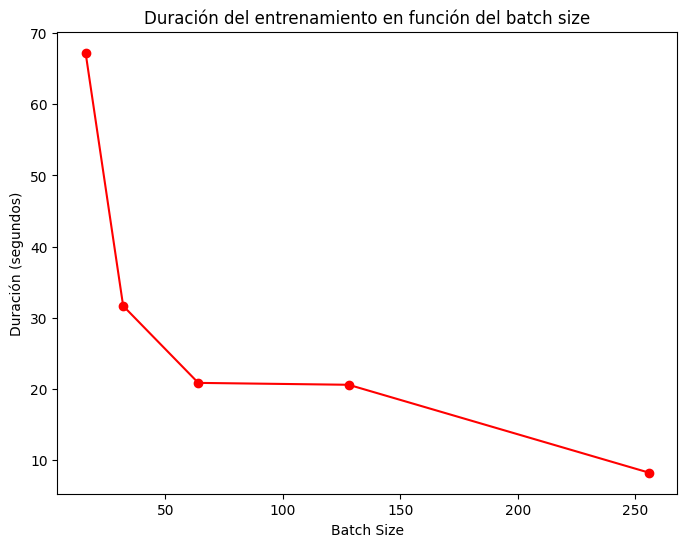

In [ ]:

durations = [duration_batch_16, duration_model_GAP1D, duration_model_batch_64, duration_model_batch_128, duration_model_256]
batch_sizes = [16, 32, 64, 128, 256]

# Llamar a la función  de comparativa de duraciones con los datos
plot_training_durations_line(durations, batch_sizes)

### 4.4 Probar con batch normalization

In [ ]:
model_batch_norm = Sequential()

# Capa de Embedding con Word2Vec
model_batch_norm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                          weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# GlobalAveragePooling1D para obtener la representación de la secuencia
model_batch_norm.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization para mejorar la estabilidad del entrenamiento
model_batch_norm.add(Dense(64, activation='relu'))  # Capa densa adicional
model_batch_norm.add(BatchNormalization())  # Batch Normalization después de la capa densa

# Capa de salida
model_batch_norm.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_batch_norm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_batch_norm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │      19,520,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,520,700 (74.47 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,520,700 (74.47 MB)

### ¿Qué se ha añadido?:

- BatchNormalization(): Después de la capa densa con 64 neuronas y activación ReLU, se añade Batch Normalization. Esto normaliza las activaciones de la capa anterior durante el entrenamiento, lo que ayuda a mejorar la velocidad de convergencia y puede estabilizar el aprendizaje.

- Capa densa adicional: He añadido una capa densa adicional con 64 neuronas y activación ReLU para que el modelo pueda aprender características más complejas antes de la predicción final.

#### ¿Por qué Batch Normalization?
La Batch Normalization mejora la estabilidad del entrenamiento y permite usar tasas de aprendizaje más altas, lo que puede mejorar tanto la accuracy como reducir la pérdida (loss). Además, reduce la sensibilidad del modelo a la inicialización de los pesos, lo que es beneficioso en redes más profundas o complejas.

In [ ]:
# Entrenar el modelo
start_time = time.time()
batch_norm_history = model_batch_norm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_batch_norm = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_batch_norm,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8022 - loss: 0.4371 - val_accuracy: 0.8524 - val_loss: 0.3384
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8463 - loss: 0.3559 - val_accuracy: 0.8516 - val_loss: 0.3395
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8500 - loss: 0.3488 - val_accuracy: 0.8544 - val_loss: 0.3348
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8524 - loss: 0.3458 - val_accuracy: 0.8501 - val_loss: 0.3376
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8501 - loss: 0.3450 - val_accuracy: 0.8530 - val_loss: 0.3296
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8520 - loss: 0.3418 - val_accuracy: 0.8564 - val_loss: 0.3255
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8540 - loss: 0.3394 - val_accuracy: 0.8558 - val_loss: 0.3268
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8563 - loss: 0.3369 - 

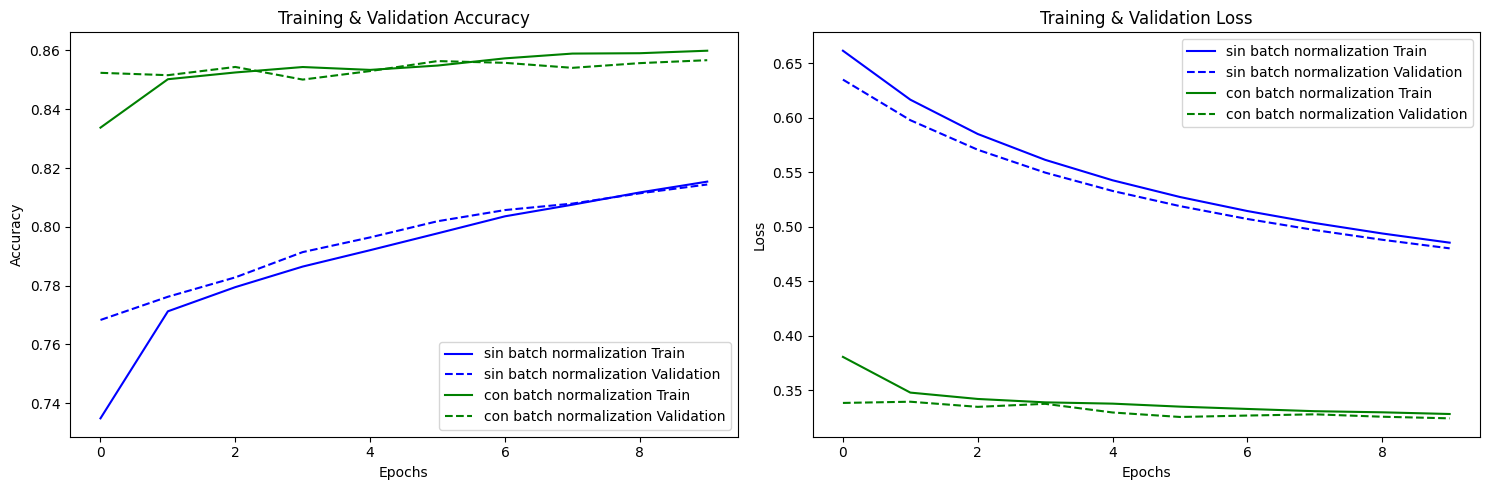

In [ ]:
graficar_entrenamiento([GAP1D_history, batch_norm_history], ['sin batch normalization', 'con batch normalization'], ['b', 'g'])

### 4.5 Probar añadiendo una capa recurrente

#### 4.5.1  Añadiendo una capa GRU:

In [ ]:
model_GRU = Sequential()

# Capa de Embedding con Word2Vec
model_GRU.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                        weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir capa GRU
model_GRU.add(GRU(64, return_sequences=True))  # Capa GRU con 64 unidades

# GlobalAveragePooling1D para obtener la representación de la secuencia
model_GRU.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization para mejorar la estabilidad del entrenamiento
model_GRU.add(Dense(64, activation='relu'))  # Capa densa adicional
model_GRU.add(BatchNormalization())  # Batch Normalization después de la capa densa

# Capa de salida
model_GRU.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_GRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
start_time = time.time()
GRU_history = model_GRU.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_GRU = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GRU,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 47ms/step - accuracy: 0.8242 - loss: 0.3960 - val_accuracy: 0.8279 - val_loss: 0.3969
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.8729 - loss: 0.3004 - val_accuracy: 0.8838 - val_loss: 0.2741
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 44ms/step - accuracy: 0.8864 - loss: 0.2741 - val_accuracy: 0.8911 - val_loss: 0.2615
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.8974 - loss: 0.2517 - val_accuracy: 0.8857 - val_loss: 0.2796
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9083 - loss: 0.2304 - val_accuracy: 0.8888 - val_loss: 0.2806
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9184 - loss: 0.2074 - val_accuracy: 0.8863 - val_loss: 0.2965
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9297 - loss: 0.1844 - val_accuracy: 0.8832 - val_loss: 0.3138
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9415 -

#### 4.5.2  Añadiendo una capa LSTM:

In [ ]:
model_LSTM = Sequential()

# Capa de Embedding con Word2Vec
model_LSTM.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                         weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir capa LSTM
model_LSTM.add(LSTM(64, return_sequences=True))  # Capa LSTM con 64 unidades

# GlobalAveragePooling1D para obtener la representación de la secuencia
model_LSTM.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization para mejorar la estabilidad del entrenamiento
model_LSTM.add(Dense(64, activation='relu'))  # Capa densa adicional
model_LSTM.add(BatchNormalization())  # Batch Normalization después de la capa densa

# Capa de salida
model_LSTM.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
start_time = time.time()
LSTM_history = model_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
end_time = time.time()
duration_model_LSTM = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_LSTM,2)} segundos")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 45ms/step - accuracy: 0.8289 - loss: 0.3902 - val_accuracy: 0.8646 - val_loss: 0.3167
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - accuracy: 0.8767 - loss: 0.2964 - val_accuracy: 0.8880 - val_loss: 0.2667
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8893 - loss: 0.2688 - val_accuracy: 0.8881 - val_loss: 0.2663
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9008 - loss: 0.2465 - val_accuracy: 0.8869 - val_loss: 0.2739
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.9122 - loss: 0.2249 - val_accuracy: 0.8745 - val_loss: 0.3163
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9223 - loss: 0.2026 - val_accuracy: 0.8755 - val_loss: 0.3211
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.9345 - loss: 0.1778 - val_accuracy: 0.8765 - val_loss: 0.3364
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9444 -

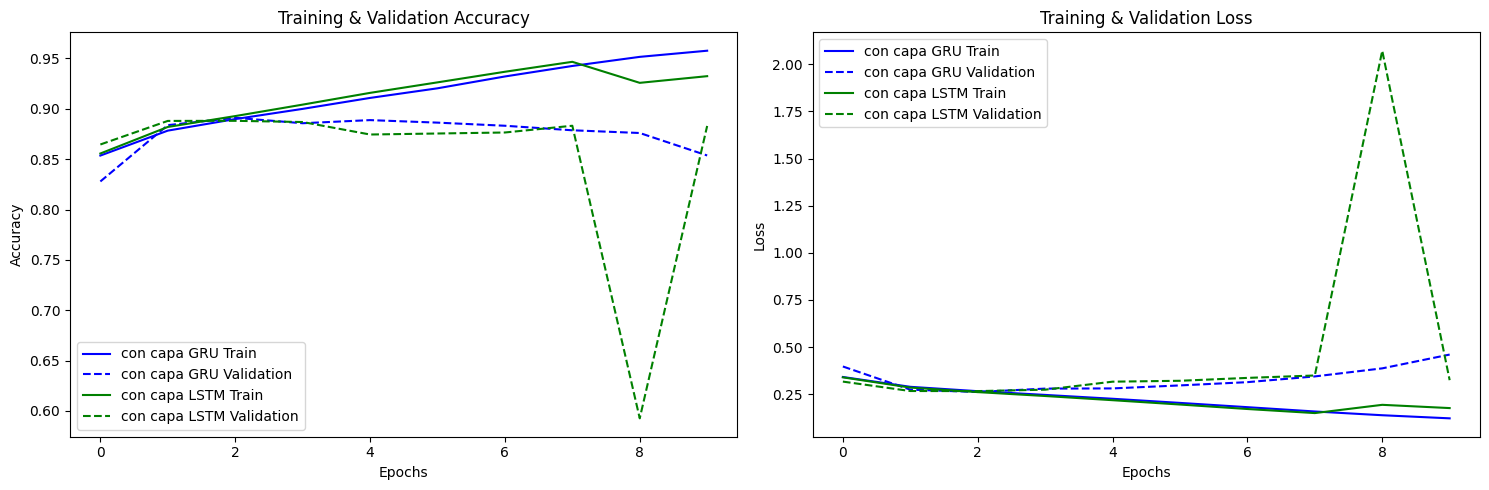

In [ ]:
graficar_entrenamiento([GRU_history, LSTM_history], ['con capa GRU', 'con capa LSTM'], ['b', 'g'])

Nos quedamos con GRU. Ha mejorado el accuracy y el loss, pero volvemos a tener overfitting. Vamos a probar con diferentes configuraciones:

#### a) añadir dropout al 30%:

In [ ]:
model_GRU_dropout = Sequential()

# Capa de Embedding con Word2Vec
model_GRU_dropout.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                         weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir capa LSTM con Dropout
model_GRU_dropout.add(GRU(64, return_sequences=True))
model_GRU_dropout.add(Dropout(0.3))  # Dropout del 30%

# GlobalAveragePooling1D
model_GRU_dropout.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization
model_GRU_dropout.add(Dense(64, activation='relu'))
model_GRU_dropout.add(BatchNormalization())
model_GRU_dropout.add(Dropout(0.3))  # Dropout del 30%

# Capa de salida
model_GRU_dropout.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_GRU_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Además, añadiremos early stopping:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [ ]:
start_time = time.time()
GRU_dropout_history = model_GRU_dropout.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
duration_model_GRU_dropout = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GRU_dropout,2)} segundos")

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - accuracy: 0.8203 - loss: 0.4053 - val_accuracy: 0.7876 - val_loss: 0.4781
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - accuracy: 0.8706 - loss: 0.3065 - val_accuracy: 0.8778 - val_loss: 0.2843
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.8819 - loss: 0.2836 - val_accuracy: 0.8848 - val_loss: 0.2690
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.8929 - loss: 0.2637 - val_accuracy: 0.8865 - val_loss: 0.2702
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9009 - loss: 0.2437 - val_accuracy: 0.8861 - val_loss: 0.2681
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.9041 - loss: 0.2410 - val_accuracy: 0.7319 - val_loss: 0.5993
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.8793 - loss: 0.2933 - val_accuracy: 0.8193 - val_loss: 0.4275
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.8961 -

#### b) Reducir el número de neuronas en la capa GRU:

En lugar de 64 unidades, probamos con 32. Además, añadiremos regularización L1 y L2. La regularización L2 penaliza los pesos grandes en la red neuronal, lo que puede ayudar a evitar el overfitting:

In [ ]:
from tensorflow.keras.regularizers import l1, l2

In [ ]:
model_GRU_32 = Sequential()

# Capa de Embedding con Word2Vec
model_GRU_32.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                         weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir capa LSTM con Dropout
model_GRU_32.add(GRU(32, return_sequences=True))

# GlobalAveragePooling1D
model_GRU_32.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization
model_GRU_32.add(Dense(64, activation='relu'))
model_GRU_32.add(BatchNormalization())

# Capa de salida
model_GRU_32.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Compilar el modelo
model_GRU_32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
start_time = time.time()
GRU_32_history = model_GRU_32.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
duration_model_GRU_32 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GRU_32,2)} segundos")

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - accuracy: 0.8246 - loss: 0.4742 - val_accuracy: 0.8722 - val_loss: 0.3315
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.8710 - loss: 0.3381 - val_accuracy: 0.8756 - val_loss: 0.3162
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - accuracy: 0.8814 - loss: 0.3109 - val_accuracy: 0.8700 - val_loss: 0.3240
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.8883 - loss: 0.2928 - val_accuracy: 0.8744 - val_loss: 0.3156
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.8949 - loss: 0.2782 - val_accuracy: 0.8766 - val_loss: 0.3140
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Tiempo de ejecución del entrenamiento: 330.0 segundos


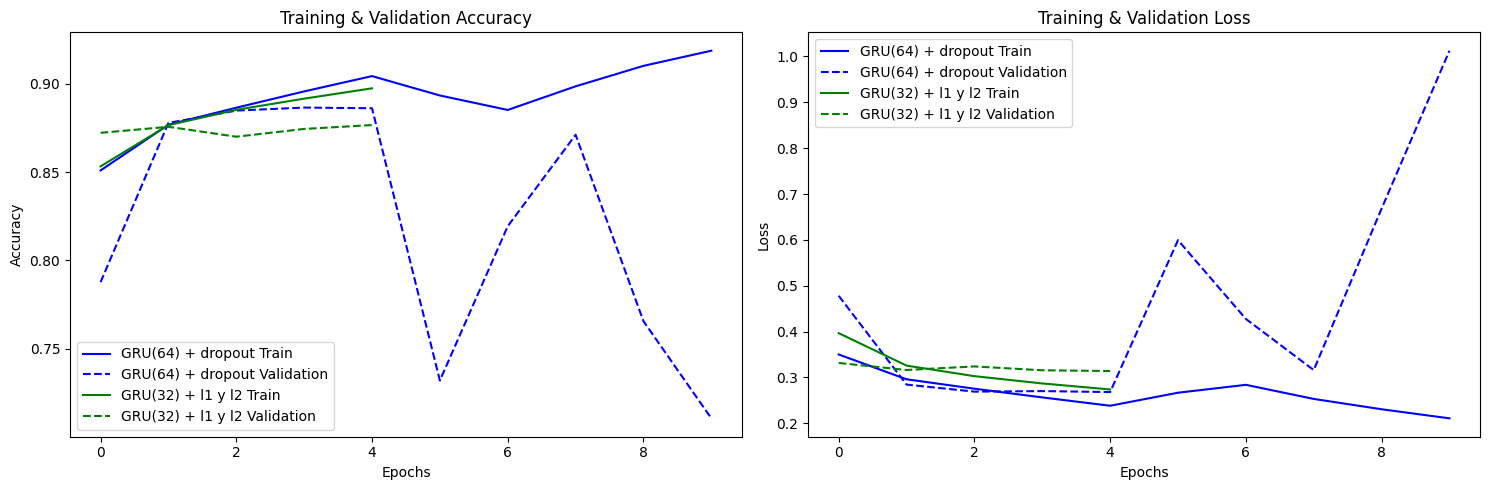

In [ ]:
graficar_entrenamiento([GRU_dropout_history, GRU_32_history], ['GRU(64) + dropout', 'GRU(32) + l1 y l2'], ['b', 'g'])

#### Conclusiones:

El dropout vuelve a crear overfitting, por lo que no es adecuado.


#### Solución a probar: Usar SpatialDropout1D en lugar de Dropout

En secuencias, SpatialDropout1D es más adecuado que Dropout, ya que apaga características completas (dimensiones de embedding) en lugar de apagar neuronas individuales. Esto puede ayudar al modelo a capturar mejor las relaciones temporales en secuencias como texto.
Vamos a sustituir el Dropout estándar por SpatialDropout1D justo después de la capa Embedding:

In [ ]:
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:
model_GRU_spatial = Sequential()

# Capa de Embedding con Word2Vec
model_GRU_spatial.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                           weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir SpatialDropout1D después de la capa Embedding
model_GRU_spatial.add(SpatialDropout1D(0.3))

# Añadir capa GRU con Dropout
model_GRU_spatial.add(GRU(128, return_sequences=True))

# GlobalAveragePooling1D
model_GRU_spatial.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization
model_GRU_spatial.add(Dense(128, activation='relu'))
model_GRU_spatial.add(BatchNormalization())

# Capa de salida con regularización L2
model_GRU_spatial.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Compilar el modelo con tasa de aprendizaje ajustada
model_GRU_spatial.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Además, vamos a probar con mas patience en early stopping y añadir ReduceLROnPlateau. Al entrenar, la tasa de aprendizaje puede necesitar ajustes. Usar el callback ReduceLROnPlateau permite que la tasa de aprendizaje disminuya cuando la pérdida de validación se estabiliza, lo que puede mejorar la convergencia:

In [ ]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau

In [ ]:
# Configurar EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001, verbose=1)

### Resumen de las mejoras:

- SpatialDropout1D para mejorar la robustez de la capa de embeddings en secuencias.
- Aumentar las unidades GRU a 128 para capturar más información secuencial.
- Regularización L1 y L2 ajustada en la capa de salida.
- Capas densas adicionales para mejorar la extracción de características.
- Ajuste en la tasa de aprendizaje para mejorar la convergencia.
- Uso de ReduceLROnPlateau y EarlyStopping para optimizar el proceso de entrenamiento.

In [ ]:
start_time = time.time()
GRU_spatial_history = model_GRU_spatial.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
end_time = time.time()
duration_model_GRU_spatial = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GRU_spatial,2)} segundos")

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - accuracy: 0.7243 - loss: 0.6862 - val_accuracy: 0.8469 - val_loss: 0.4385 - learning_rate: 1.0000e-04
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8183 - loss: 0.4782 - val_accuracy: 0.8537 - val_loss: 0.3897 - learning_rate: 1.0000e-04
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - accuracy: 0.8348 - loss: 0.4253 - val_accuracy: 0.8526 - val_loss: 0.3797 - learning_rate: 1.0000e-04
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.8446 - loss: 0.3977 - val_accuracy: 0.8577 - val_loss: 0.3642 - learning_rate: 1.0000e-04
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 89s 60ms/step - accuracy: 0.8492 - loss: 0.3866 - val_accuracy: 0.8654 - val_loss: 0.3509 - learning_rate: 1.0000e-04
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.8557 - loss: 0.3745 - val_accuracy: 0.8705 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━

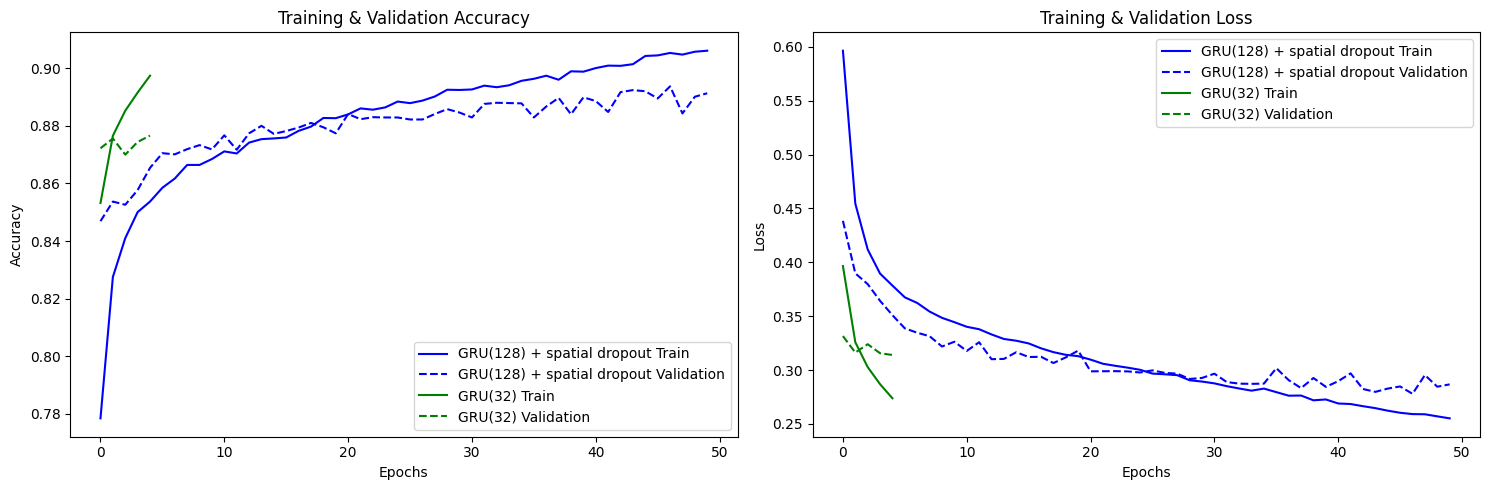

In [ ]:
graficar_entrenamiento([GRU_spatial_history, GRU_32_history], ['GRU(128) + spatial dropout', 'GRU(32)'], ['b', 'g'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


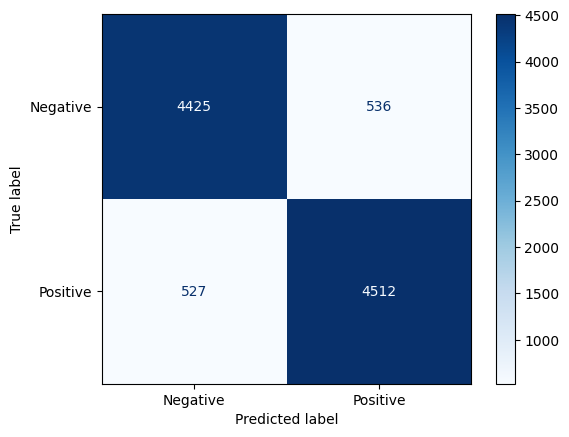

In [ ]:
# Mostrar la matriz de confusión del modelo
mostrar_matriz_confusion(model_GRU_spatial, X_val, y_val)

Vamos a comparar una GRU de 128 VS una GRU de 64:

In [ ]:
model_GRU_spatial_64 = Sequential()

# Capa de Embedding con Word2Vec
model_GRU_spatial_64.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=VECTOR_SIZE,
                           weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))

# Añadir SpatialDropout1D después de la capa Embedding
model_GRU_spatial_64.add(SpatialDropout1D(0.3))

# Añadir capa GRU con Dropout
model_GRU_spatial_64.add(GRU(64, return_sequences=True))

# GlobalAveragePooling1D
model_GRU_spatial_64.add(GlobalAveragePooling1D())

# Capa densa con Batch Normalization
model_GRU_spatial_64.add(Dense(64, activation='relu'))
model_GRU_spatial_64.add(BatchNormalization())

# Capa de salida con regularización L2
model_GRU_spatial_64.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Compilar el modelo con tasa de aprendizaje ajustada
model_GRU_spatial_64.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

In [ ]:
start_time = time.time()
GRU_spatial_64_history = model_GRU_spatial_64.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])
end_time = time.time()
duration_model_GRU_spatial_64 = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento: {round(duration_model_GRU_spatial_64,2)} segundos")

NameError: name 'time' is not defined

In [ ]:
graficar_entrenamiento([GRU_spatial_64_history, GRU_spatial_history], ['GRU(64) + spatial dropout', 'GRU(128) + spatial dropout'], ['b', 'g'])

NameError: name 'graficar_entrenamiento' is not defined

In [ ]:
models = ['GRU(64) + spatial dropout', 'GRU(128) + spatial dropout', 'GRU(64) sin spatial dropout', 'LSTM(64)', 'sin GRU ni LSTM', 'simple + GAP1D']
durations = [duration_model_GRU_spatial_64, duration_model_GRU_spatial, duration_model_GRU, duration_model_LSTM, duration_model_batch_norm, duration_model_GAP1D]

plot_training_duration(models, durations)

In [ ]:
# Mostrar la matriz de confusión del modelo
mostrar_matriz_confusion(model_GRU_spatial_64, X_val, y_val)

## 5. Conclusión final y explicación de las decisiones

Este diseño busca un equilibrio entre la complejidad suficiente para capturar patrones importantes y la prevención del sobreajuste:

### 1. **Embedding Layer**:
```python
model_GRU_spatial_64.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                                   output_dim=VECTOR_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=max_sequence_length,
                                   trainable=False))
```
- **Función**: La capa de **Embedding** convierte las palabras en secuencias de texto en vectores densos de tamaño `VECTOR_SIZE`, que representan las relaciones semánticas entre las palabras. En este caso, se utiliza un embedding preentrenado (como **Word2Vec**), que permite aprovechar la representación de palabras basada en datos externos o más grandes.
- **Decisión**: Usar **Word2Vec** como embeddings preentrenados es una buena decisión cuando se trabaja con textos, ya que estos embeddings capturan relaciones semánticas entre palabras que mejoran la comprensión del contexto.
- **trainable=False**: Esto asegura que los embeddings preentrenados no se modifiquen durante el entrenamiento, ya que queremos que la red mantenga las relaciones semánticas ya aprendidas.

### 2. **SpatialDropout1D**:
```python
model_GRU_spatial_64.add(SpatialDropout1D(0.3))
```
- **Función**: **SpatialDropout1D** apaga aleatoriamente características enteras en lugar de apagar neuronas individuales. En el caso de secuencias, esto significa que apaga "dimensiones" del embedding completo en lugar de elementos individuales, ayudando a preservar la estructura secuencial.
- **Decisión**: Se utiliza **SpatialDropout1D** en lugar de **Dropout** tradicional para trabajar de manera más eficiente en datos secuenciales como texto, ya que en lugar de apagar neuronas individuales (lo que puede ser menos efectivo en secuencias), apaga características enteras del embedding. Esto ayuda a mejorar la robustez del modelo y reducir el **overfitting**.

### 3. **GRU Layer**:
```python
model_GRU_spatial_64.add(GRU(64, return_sequences=True))
```
- **Función**: La capa **GRU** es un tipo de red recurrente que captura relaciones secuenciales y dependencias a largo plazo dentro de las secuencias de texto. Aquí, se utilizan 64 unidades que controlan cuántos aspectos de la secuencia se pueden aprender. El parámetro `return_sequences=True` asegura que la capa **GRU** devuelva la secuencia completa en lugar de solo la última salida.
- **Decisión**: Se utiliza **GRU** en lugar de **LSTM** porque son más eficientes computacionalmente y, en muchos casos, ofrecen un rendimiento similar en problemas de texto. **64 unidades** es un buen equilibrio entre la capacidad de capturar suficiente información secuencial sin sobrecargar el modelo, y `return_sequences=True` permite que la siguiente capa (GlobalAveragePooling1D) tenga acceso a toda la secuencia procesada.

### 4. **GlobalAveragePooling1D**:
```python
model_GRU_spatial_64.add(GlobalAveragePooling1D())
```
- **Función**: **GlobalAveragePooling1D** convierte la secuencia completa de salidas de la capa GRU en una sola representación de tamaño fijo, tomando el promedio de todas las salidas de la secuencia a lo largo de la dimensión temporal.
- **Decisión**: Esta capa es útil para reducir la dimensionalidad y evitar el sobreajuste. En lugar de pasar la secuencia completa a las siguientes capas densas, se toma un resumen global, lo que ayuda a simplificar la representación de la secuencia. También se evita el uso de una capa densa que podría llevar a un exceso de parámetros, lo cual podría causar **overfitting**.

### 5. **Dense Layer (con ReLU) y BatchNormalization**:
```python
model_GRU_spatial_64.add(Dense(64, activation='relu'))
model_GRU_spatial_64.add(BatchNormalization())
```
- **Función**: La capa **Dense** con 64 unidades y activación **ReLU** permite que el modelo aprenda relaciones más complejas entre las características de la secuencia ya procesada. **Batch Normalization** normaliza las activaciones de esta capa durante el entrenamiento, lo que estabiliza y acelera el proceso de entrenamiento.
- **Decisión**: La capa **ReLU** introduce no linealidad, lo cual es importante para que el modelo aprenda patrones complejos. **Batch Normalization** reduce la variación interna del gradiente, haciendo el entrenamiento más estable y permitiendo el uso de tasas de aprendizaje más altas sin que el modelo sea tan sensible a la inicialización de pesos.

### 6. **Output Layer (con regularización L1/L2)**:
```python
model_GRU_spatial_64.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
```
- **Función**: La capa de salida usa una sola neurona con activación **sigmoid** para realizar la clasificación binaria (positivo o negativo). La regularización **L1/L2** introduce penalización tanto a los pesos grandes como a los muchos pesos, lo que ayuda a mejorar la generalización y evitar el sobreajuste.
- **Decisión**: Usar la activación **sigmoid** es la elección estándar para tareas de clasificación binaria. La **regularización L1/L2** ayuda a limitar los valores de los pesos del modelo, reduciendo el riesgo de overfitting al penalizar pesos innecesariamente grandes (L2) o demasiados pesos pequeños (L1).

### 7. **Compilación del modelo**:
```python
model_GRU_spatial_64.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
```
- **Función**: El optimizador **Adam** se utiliza debido a su eficiencia en la actualización de los pesos de los modelos de redes neuronales, combinando las ventajas de **RMSProp** y **Momentum**. El **learning rate** de `0.0001` es un valor reducido que permite un aprendizaje más gradual, lo cual es útil para evitar oscilaciones o sobreajustes prematuros. El **binary_crossentropy** es el estándar para problemas de clasificación binaria.
- **Decisión**: Usar **Adam** permite que el modelo se entrene de manera eficiente sin tener que ajustar manualmente la tasa de aprendizaje durante el proceso. El uso de una tasa de aprendizaje baja (`0.0001`) asegura que el modelo no haga actualizaciones de peso muy grandes, lo cual es importante para lograr un ajuste más fino de los pesos del modelo en problemas donde las características de entrada pueden ser complejas.